#**preprocessing**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [ ]:
df = pd.read_csv('XSS_dataset.csv', index_col = 0)
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [ ]:
def data2char_index(X, max_len):
    alphabet = " abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    result = []
    for data in X:
        mat = []
        for ch in data:
            if ch not in alphabet:
                continue
            mat.append(alphabet.index(ch))
        result.append(mat)
    X_char = tf.keras.preprocessing.sequence.pad_sequences(np.array(result, dtype=object), padding='post',
                                                           truncating='post', maxlen=max_len)
    return X_char

In [ ]:
data = df['Sentence'].values
label = df['Label'].values

trainX, testX, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

x_train = data2char_index(trainX, max_len=1000)
x_test = data2char_index(testX, max_len=1000)

In [ ]:
x_train.shape

(10944, 1000)

In [ ]:
x_train = tf.reshape(x_train, (10944,1000))
x_test = tf.reshape(x_test, (2736,1000))

print(x_train.shape,x_test.shape)

(10944, 1000) (2736, 1000)


#**learning**

In [ ]:
def get_charcnn_model(max_len):
    main_input = tf.keras.layers.Input(shape=(max_len,))

    embedder = tf.keras.layers.Embedding(
        input_dim=70,
        output_dim=80,
        input_length=max_len,
        trainable=False
    )
    embed = embedder(main_input)

    cnn1 = tf.keras.layers.Conv1D(16, 5, padding='same', strides=1, activation='relu')(embed)
    cnn1 = tf.keras.layers.MaxPooling1D(pool_size=12)(cnn1)

    # cnn2 = tf.keras.layers.Conv1D(32, 10, padding='same', strides=1, activation='relu')(embed)
    # cnn2 = tf.keras.layers.MaxPooling1D(pool_size=11)(cnn2)

    cnn3 = tf.keras.layers.Conv1D(16, 10, padding='same', strides=1, activation='relu')(embed)
    cnn3 = tf.keras.layers.MaxPooling1D(pool_size=11)(cnn3)

    cnn = tf.keras.layers.concatenate([cnn1,cnn3], axis=1)
    flat = tf.keras.layers.Flatten()(cnn)
    drop = tf.keras.layers.Dropout(0.3)(flat)
    dense1 = tf.keras.layers.Dense(512, activation='relu')(drop)
    dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)
    main_output = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
    model = tf.keras.Model(inputs=main_input, outputs=main_output)
    return model

In [ ]:
model = get_charcnn_model(max_len=1000)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 80)             5600      ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 1000, 16)             6416      ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1000, 16)             12816     ['embedding[0][0]']           
                                                                                              

In [ ]:
batch_size = 128
num_epoch = 10
model_log = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epoch,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/10
86/86 [==============================] - 14s 19ms/step - loss: 0.2072 - accuracy: 0.9065 - val_loss: 0.0429 - val_accuracy: 0.9861
Epoch 2/10
86/86 [==============================] - 1s 14ms/step - loss: 0.0243 - accuracy: 0.9922 - val_loss: 0.0129 - val_accuracy: 0.9960
Epoch 3/10
86/86 [==============================] - 1s 14ms/step - loss: 0.0078 - accuracy: 0.9977 - val_loss: 0.0098 - val_accuracy: 0.9956
Epoch 4/10
86/86 [==============================] - 2s 20ms/step - loss: 0.0063 - accuracy: 0.9976 - val_loss: 0.0076 - val_accuracy: 0.9967
Epoch 5/10
86/86 [==============================] - 1s 16ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0082 - val_accuracy: 0.9971
Epoch 6/10
86/86 [==============================] - 1s 16ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0044 - val_accuracy: 0.9974
Epoch 7/10
86/86 [==============================] - 1s 14ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0032 - val_accuracy: 0.9989
Epoch 8/10
8

In [ ]:
pred = model.predict(x_test)
y_pred = np.int64(pred>0.5)
print(x_test)

86/86 [==============================] - 0s 3ms/step
tf.Tensor(
[[62 22  1 ...  0  0  0]
 [ 0 62 46 ...  0  0  0]
 [ 0 62 46 ...  0  0  0]
 ...
 [ 0 62 46 ...  0  0  0]
 [ 0 62 46 ...  0  0  0]
 [62  8 18 ...  0  0  0]], shape=(2736, 1000), dtype=int32)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2}".format(accuracy, precision, recall))

 Accuracy : 0.9996345029239766 
 Precision : 1.0 
 Recall : 0.9993108201240524


#**plot**


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


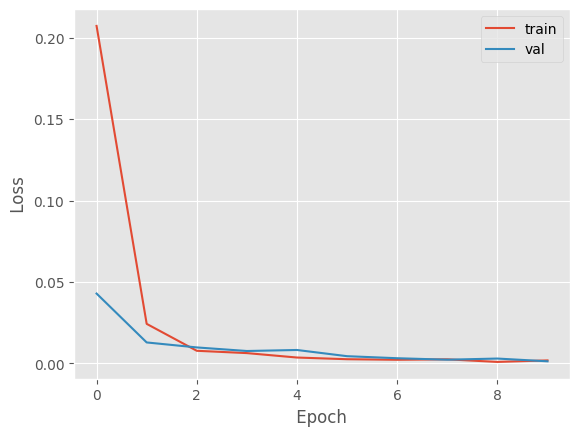

<Figure size 640x480 with 0 Axes>

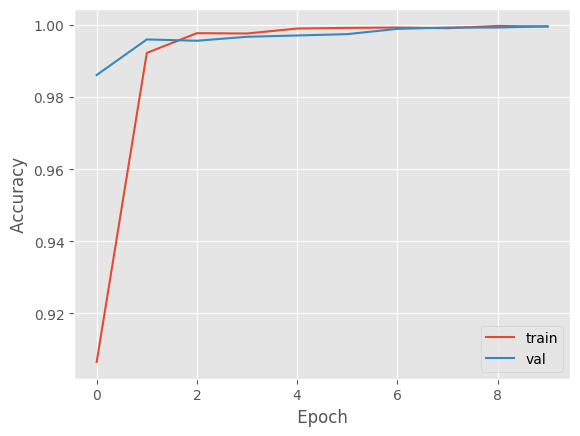

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)

plt.style.use('ggplot')
histr=model_log.history
accuracies = histr['accuracy']
valacc = histr['val_accuracy']
loss = histr['loss']
vallos = histr['val_loss']

# print(accuracies)
# print(valacc)
# print(loss)

plt.figure()
plt.xlabel(' Epoch ')
plt.ylabel(' Loss ')
plt.plot(loss,label='train')
plt.plot(vallos,label='val')
plt.legend()
plt.show()
plt.savefig('loss.png')


plt.figure()
plt.xlabel(' Epoch ')
plt.ylabel(' Accuracy ')
plt.plot(accuracies,label='train')
plt.plot(valacc,label='val')
plt.legend()
plt.show()
plt.savefig('accu.png')


In [ ]:
# prede = model.predict(x_test)
# y_pred = np.int64(pred>0.5)
print(x_test[:8])
predee = model.predict(x_test[:8])
y_pred = np.int64(predee>0.5)
print(predee)
print('%f' % predee[3])


tf.Tensor(
[[62 22  1 ...  0  0  0]
 [ 0 62 46 ...  0  0  0]
 [ 0 62 46 ...  0  0  0]
 ...
 [62 13  1 ...  0  0  0]
 [62  1 16 ...  0  0  0]
 [62 16 63 ...  0  0  0]], shape=(8, 1000), dtype=int32)
1/1 [==============================] - 0s 94ms/step
[[9.9999988e-01]
 [7.6337872e-17]
 [1.4728908e-05]
 [9.9999976e-01]
 [3.9469868e-13]
 [9.9999988e-01]
 [1.0000000e+00]
 [2.7114441e-17]]
1.000000


# *test*

In [ ]:
# loss_object = tf.keras.losses.CategoricalCrossentropy()
loss_object = tf.keras.losses.BinaryCrossentropy()

def create_adversarial_pattern(input_pattern, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_pattern)
    print("------",input_pattern.shape,input_pattern)
    prediction = model(input_pattern)
    print("......",prediction)
    loss = loss_object(input_label, prediction)
    print("loass", loss)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_pattern)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
# labrador_retriever_index = 208
# label = tf.reshape(label, (1, image_probs.shape[-1]))
# label = tf.reshape(y_test,[1,2736])

label = y_train[0]
label = tf.reshape(label, (1, ))
print("----------label")
print(type(label))
print(label.shape)
print(label)
# input_patt.

print("--------image")

image = x_test[0]
image = tf.reshape(image, (1, 1000))

print(type(image))
print(image.shape)
# print(image)


# print(input_pattern[0].shape , label[0].shape)
# label
perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

# #**fgsm Attack**

In [ ]:
device = torch.device("cuda" if (True and torch.cuda.is_available()) else "cpu")
import torch.nn.functional as F

In [ ]:
print(x_train.shape,"---",y_train.shape)
print(type(x_train),"---",type(y_train))


(10944, 1000) --- (10944,)
<class 'tensorflow.python.framework.ops.EagerTensor'> --- <class 'numpy.ndarray'>


In [ ]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [ ]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      print("----------------",data.shape , target.shape)
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)

      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples

In [ ]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()